# This notebook needs all the estimates obtained by simply running the Python module that contains the funtions that I use (the pickle file)

In [5]:
################################################
# Notebook for "Dissecting market expectations 
# in the cross-section of book-to-market ratios"
#
# Critical Finance Review  - February 2021
# Thiago de Oliveira Souza
################################################

# For the multiprocessing part:
#import itertools
#from functools import partial
#import concurrent.futures
#import time

#Monitor progress loop
from tqdm.notebook import tqdm as tqdm

#import pickle
import seaborn as sns
#import ipystata
#import pandas as pd
#import numpy as np
import datetime as dt
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#import os
#import psycopg2 
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
#from scipy import stats
import scipy.io
#import statsmodels.api as sm
#import multiprocessing

# Import module that contains all the PLS functions that I wrote:
#################################################################

# Append path:
import sys
sys.path.append('../Mymodules')

# Import
from pls import *

In [6]:
# Open pickle saved from running the module (long estimation time)
pickle_incomplete = False


local = os.path.join(os.getcwd(), 
                     'local', 
                     'CFR72.mod')
                     #'CFR72i.mod')

model_dic = pickle.load(open(local, 'rb'))

# Sometimes output from the module has only recursive part
if pickle_incomplete:
    for key in tqdm(model_dic):
        non_recursive_estimates(model_dic[key], Std2=True)

    # Save
    local = os.path.join(os.getcwd(), 
                         'local', 
                         'CFR72.mod')
    pickle.dump(model_dic, open(local, 'wb')) 
    
    

# General parameters to create and save the TEX tables

In [7]:
# Tex files (to be created):
save1 = os.path.join(os.getcwd(), 'Output general', 'Table1.tex')
save2 = os.path.join(os.getcwd(), 'Output general', 'Table2.tex')

# Dictionary with regressors' labels
####################################

# Table 1 CODE: (std,logBM)
indices1 = ['std','logBM']
reg_dic = {(True, True): '$bm_{\sigma,t-1}$',
           (True, False): '$BM_{\sigma,t-1}$',
           (False, True): '$bm_{t-1}$'
          }

# Table 2 CODE: (lagBM, minH)
indices2 = ['lagBM','minH'] 
reg_dic2 = {(1, 0.8): '$bm_{\sigma,t-1}$',
           (0, 0.8): '$bm_{\sigma,t}$',
           (1, 0.2): '$bm_{\sigma,t-1}$',
           (0, 0.2): '$bm_{\sigma,t}$',
          }

# Print-friendly column headers:
columns_to_print = {'ISR2Y': '$IS_y$ $R^2$',
                    'ISR2pY': '$p$',
                    'OOSR2Y': '$OOS_y$ $R^2$',
                    'OOSR2pY': '$p$',
                    'ISR2M': '$IS_m$ $R^2$',
                    'ISR2pM': '$p$',
                    'OOSR2M': '$OOS_m$ $R^2$',
                    'OOSR2pM': '$p$',
                   }

# Function to fill and save latex table

In [8]:
def fill_table(pd_list, model_dic, reg_dic, columns_to_print, indices, save=False):
    table = pd_list.copy()
    #Convert dataframe to array of tuples:
    YearKeys = list(table.itertuples(index=False, name=None))
    
    # Replace 12 by 1 in horizon, then crete new tupple
    table['horizon'] = 1
    MonthKeys = list(table.itertuples(index=False, name=None))
    
    # Now the monthly models
    table['keyY'] = YearKeys
    table['keyM'] = MonthKeys
    
    table['Regressors'] = list(table[indices].itertuples(index=False, name=None))
    table['Regressors'] = table['Regressors'].map(reg_dic)
    
    table.set_index(['target', 'Regressors','Nx'], inplace=True)
    table = table[['keyY','keyM']]
    
    for h in ['Y','M']:
        table['ISR2'+h] = table['key'+h].apply(lambda key: model_dic[key].ISR2).apply('{:.2f}'.format)
        table['ISR2p'+h] = table['key'+h].apply(lambda key: model_dic[key].pNW).apply('{:.2f}'.format)
        table['OOSR2'+h] = table['key'+h].apply(lambda key: model_dic[key].OOSR230)
        table['OOSR2p'+h] = np.where(table['OOSR2'+h] >=0,
                                  table['key'+h].apply(lambda key: model_dic[key].pENC30),
                                  '-')
        # Now fix the format (not before, because of the p-value condition)
        table['OOSR2'+h] = table['OOSR2'+h].apply('{:.2f}'.format)
    
    table.rename(columns=columns_to_print, inplace=True)
    table.index.names = [None,None,None]
    table.drop(['keyY','keyM'], axis=1, inplace=True)

    if save is not False:
        # Set alignment of columns (the indices are left, rest is right)
        calig = 'lll'
        for i in range(table.shape[1]):
            calig = calig + 'r'
            
        textring = table.to_latex(escape=False,
                                  column_format = calig,
                                  multicolumn_format='c',
                                  multirow=True,
                                  #float_format = lambda x: '{:0.3f}'.format(x) if pd.notna(x) else '-',
                                  na_rep = '-')
        # Change to look better
        textring = textring.replace('\cline', '\cmidrule')
        textring = textring.replace('None', '')
        
        # Write string to file
        print(save)
        with open(save,'w') as tf:
            tf.write(textring)
    return table

# Tables 1 and 2

1. Read the keys for all models in each table from the Excel file
2. Fill the fields in the table

In [9]:
# Read tupples
T1 = pd.read_excel(os.path.normpath(os.path.join(os.getcwd(),
                                                 "Table model v3.xlsx")),
                   sheet_name='keysT1')
#                   sheet_name='noLOG')

fill_table(T1, model_dic, reg_dic, columns_to_print, indices1, save1)

C:\Users\tsouza\OneDrive - Syddansk Universitet\Python\Disaggregate\Output general\Table1.tex


$IS_y$ $R^2$   $p$ $OOS_y$ $R^2$    $p$ $IS_m$ $R^2$  \
RM $bm_{\sigma,t-1}$ 6           8.53  0.00          6.77  <0.01         0.58   
                     25         12.31  0.00          8.06  <0.01         0.89   
                     100        19.83  0.00         14.07  <0.01         2.53   
   $bm_{t-1}$        6           3.57  0.14          5.06  <0.05         0.21   
                     25          5.63  0.09          5.90  <0.05         0.37   
                     100        14.31  0.01          5.69  <0.05         2.25   
   $BM_{\sigma,t-1}$ 6           6.77  0.01          5.70  <0.01         0.27   
                     25         19.51  0.00          0.40  <0.01         2.60   
                     100        26.42  0.00         -2.86      -         3.24   
MP $bm_{\sigma,t-1}$ 6           5.92  0.02          0.73  <0.05         0.46   
                     25          9.83  0.01          2.16  <0.01         0.74   
                     100        18.14  0.00          9.26  <0.01         2.41   
   $bm_{t-1}$        6           6.95  0.04        -10.60      -         0.76   
                     25         14.40  0.00        -20.05      -         0.91   
                     100        19.18  0.00         -7.60      -         2.34   
   $BM_{\sigma,t-1}$ 6           5.52  0.03          1.29  <0.05         0.81   
                     25         19.71  0.00         -5.07      -         2.86   
                     100        27.93  0.00         -7.25      -         3.02   

                           $p$ $OOS_m$ $R^2$    $p$  
RM $bm_{\sigma,t-1}$ 6    0.03          0.67  <0.05  
                     25   0.01          0.73  <0.01  
                     100  0.01          0.63  <0.05  
   $bm_{t-1}$        6    0.39         -0.05      -  
                     25   0.20         -0.96      -  
                     100  0.05         -0.61      -  
   $BM_{\sigma,t-1}$ 6    0.19          0.19      -  
                     25   0.06         -0.07      -  
                     100  0.04         -0.29      -  
MP $bm_{\sigma,t-1}$ 6    0.06          0.31  <0.05  
                     25   0.02          0.09  <0.05  
                     100  0.03         -0.19      -  
   $bm_{t-1}$        6    0.01         -0.96      -  
                     25   0.00         -2.55      -  
                     100  0.04         -1.63      -  
   $BM_{\sigma,t-1}$ 6    0.05         -1.00      -  
                     25   0.09         -0.42      -  
                     100  0.06         -0.55      -

# Table 2 

In [10]:
T2 = pd.read_excel(os.path.normpath(os.path.join(os.getcwd(),
                                                 "Table model v3.xlsx")),
                   sheet_name='keysT2')
#                   sheet_name='no02')

fill_table(T2, model_dic, reg_dic2, columns_to_print, indices2, save2)

C:\Users\tsouza\OneDrive - Syddansk Universitet\Python\Disaggregate\Output general\Table2.tex


$IS_y$ $R^2$   $p$ $OOS_y$ $R^2$    $p$ $IS_m$ $R^2$  \
RM $bm_{\sigma,t-1}$ 6           7.65  0.00          4.05  <0.01         0.40   
                     25          9.59  0.00          2.05  <0.01         0.57   
                     100        17.45  0.00          8.21  <0.01         2.61   
   $bm_{\sigma,t}$   6           7.17  0.01          4.11  <0.01         0.43   
                     25          9.08  0.00          2.24  <0.01         1.11   
                     100        18.39  0.00          8.66  <0.01         3.90   
MP $bm_{\sigma,t-1}$ 6           5.28  0.03         -2.66      -         0.28   
                     25          7.21  0.02         -5.37      -         0.43   
                     100        16.33  0.00          2.76  <0.05         2.53   
   $bm_{\sigma,t}$   6           5.02  0.03         -2.34      -         0.36   
                     25          6.94  0.02         -5.03      -         1.39   
                     100        16.44  0.00          3.09  <0.05         3.71   

                           $p$ $OOS_m$ $R^2$    $p$  
RM $bm_{\sigma,t-1}$ 6    0.06          0.34  <0.05  
                     25   0.02          0.15  <0.05  
                     100  0.01          0.34  <0.05  
   $bm_{\sigma,t}$   6    0.05          0.14  <0.05  
                     25   0.00         -0.50      -  
                     100  0.00         -0.31      -  
MP $bm_{\sigma,t-1}$ 6    0.14         -0.10      -  
                     25   0.06         -0.50      -  
                     100  0.03         -0.35      -  
   $bm_{\sigma,t}$   6    0.11         -0.42      -  
                     25   0.00         -1.72      -  
                     100  0.00         -0.92      -

# Graph cumulative sum of squares

C:\Users\tsouza\OneDrive - Syddansk Universitet\Python\Disaggregate\Output general\Main_Figure.pdf


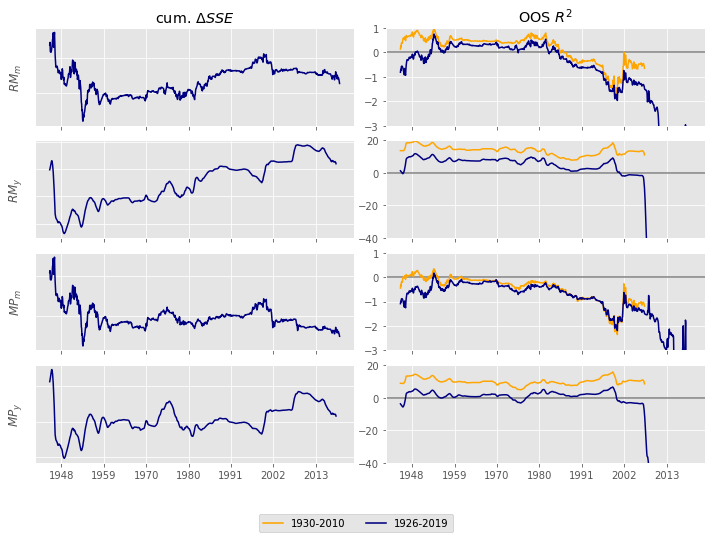

In [11]:
def graph_different_models(all_models_dic, keys_plot, LineTitle, ColTitle, SeriesLabels, SeriesLegs, Colors=False,
                           InsideLegs=True, OutsideLegs=True, Ylims=False, s=False, lowD=0, hline=False):

    if Ylims:
        if len(Ylims) == 1:
            Ylims = [Ylims[0] for i in range(len(keys_plot))]

    ######################################
    # Here the code starts
    ######################################
    plt.style.use('ggplot')
    f, ax = plt.subplots(len(keys_plot), len(SeriesLabels),
                         sharex=True, sharey=False, figsize=(12, len(SeriesLabels) * len(keys_plot)))
    plt.subplots_adjust(wspace=0.1, hspace=0.15)
    plt.set_cmap('Pastel1')
    

    for i in range(len(keys_plot)):
        for j in range(len(SeriesLabels)):
            ax[i,j].xaxis.set_major_locator(plt.MaxNLocator(9))
            #if col == (len(SeriesLabels[0]) - 1):
            #    ax[i,j].yaxis.set_label_position("right")
            #    ax[i,j].yaxis.tick_right()
            
            # graph is defined (i,j).
            if hline is not False:
                if hline[0][j] is not False:
                    ax[i,j].axhline(y=hline[0][j], color='gray', linestyle='-')
            if i == 0 and ColTitle:
                ax[i,j].set(title=ColTitle[j])
            if j == 0 and LineTitle:
                ax[i,j].set_ylabel(LineTitle[i], fontsize='large')
                #ax[i,j].set(ylabel=None)  # remove the y-axis label
                ax[i,j].set_yticklabels([])
                ax[i,j].tick_params(left=False)  # remove the ticks

            
            if Ylims[i][j]:
                ax[i,j].axis(ymin=Ylims[i][j][0], ymax=Ylims[i][j][1])

            # Inside the graph, may plot more than one model/key):
            for key in keys_plot[i][j]:
                # For each model may plot more than one series (depending on column):
                SeriesLabels[j]
                #for ks in range(len(SeriesLabels[i][j])):
                ax[i,j].plot(all_models_dic[key].OOSstat[lowD:DateLim[key[-1]]].index,
                             all_models_dic[key].OOSstat[lowD:DateLim[key[-1]]][SeriesLabels[j]],
                             linewidth=1.5,
                             color= Color[key[-1]],
                             label=SeriesLegs[j][0][key[-1]] if i == 0 else None)
                if SeriesLegs and InsideLegs:
                    ax[i, j].legend()
        if SeriesLegs is not False and OutsideLegs:
            f.legend(loc='lower center', ncol=5)
    f.align_labels()

    if s:
        print(s)
        f.savefig(s, bbox_inches='tight')

        
        
keys_plot = [[[(100,1,'RM',True,True,1,0.8,60,False)],
              [(100,1,'RM',True,True,1,0.8,60,True), (100,1,'RM',True,True,1,0.8,60,False)]],
             [[(100,12,'RM',True,True,1,0.8,60,False)],
              [(100,12,'RM',True,True,1,0.8,60,True), (100,12,'RM',True,True,1,0.8,60,False)]],
             [[(100,1,'MP',True,True,1,0.8,60,False)],
              [(100,1,'MP',True,True,1,0.8,60,True), (100,1,'MP',True,True,1,0.8,60,False)]],
             [[(100,12,'MP',True,True,1,0.8,60,False)],
              [(100,12,'MP',True,True,1,0.8,60,True), (100,12,'MP',True,True,1,0.8,60,False)]]             
            ]

#keys_plot[0][1]

SeriesLabels = ['cumSSE',
                 'R2']

#Colors = [[['navy'],
#           ['orange','navy']]]

SeriesLegs = [[{False: None,True: None}],
              [{False: '1926-2019',True: '1930-2010'}]]
#SeriesLegs[1][0][key[-1]]

LineTitle =[r'$RM_m$',
            r'$RM_y$',
            r'$MP_m$',
            r'$MP_y$',
           ]

DateLim = {False: '2020-01-31',
           True: '2008-01-31'}

Color = {False: 'navy',
         True: 'orange'}
#Color[key[-1]]

Ylims = [[False, (-3,1)],
         [False, (-40,20)],
         [False, (-3,1)],
         [False, (-40,20)]]

hline = [[False,0]]


ColTitle = ['cum. $\Delta SSE$', 'OOS $R^2$']

lowD='1945'
s = os.path.join(os.getcwd(), 'Output general', 'Main_Figure.pdf')

graph_different_models(all_models_dic=model_dic, keys_plot=keys_plot, LineTitle=LineTitle, ColTitle=ColTitle, 
                       SeriesLabels = SeriesLabels, SeriesLegs = SeriesLegs, Colors=False, InsideLegs=False,
                       OutsideLegs=True, Ylims=Ylims, s=s, lowD=lowD, hline=hline)